# ANNDL first homework

## Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, applications, Model
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from keras.applications import EfficientNetB0
from keras.applications import ConvNeXtBase
from keras.optimizers import AdamW
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import math

## Load our augmented data

In [ ]:
# Add ANNDL_Homework_1 folder to My Drive shortcuts!
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL_Homework_1

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1BaRDe1mvdZ-CVRKahDSwAMUpRHTjCvE3/ANNDL_Homework_1


In [ ]:
# Load the arrays from the .npz file
data = np.load('Original_Data_Splitted.npz')

# Access the arrays by their names
#Ho messo ft perchè rimanda a fine tuning (ft) ;)
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']

In [ ]:
# Load the arrays from the .npz file
data = np.load('Augmented_Images_Expanded.npz')

augmented_images = data['augmented_images']
augmented_labels = data['augmented_labels']

In [ ]:
# Count the occurrences of each label
unique_labels, label_counts = np.unique(np.argmax(y_train,axis=-1), return_counts=True)
print('Target labels:', unique_labels)
for u in unique_labels:
    print(f'Class {unique_labels[u]} has {label_counts[u]} samples')

healty_indices = np.where(np.argmax(y_train,axis=-1) == unique_labels[0])[0]
unhealty_indices = np.where(np.argmax(y_train,axis=-1) == unique_labels[1])[0]
#evaluate the difference in number of pictures of the 2 classes
diff = len(healty_indices)- len(unhealty_indices)
print("\nNumber of healty images:",healty_indices.shape[0])
print("Number of unhealty images:",unhealty_indices.shape[0])
print("Missing unhealty images for balance:",diff)
healty_indices = np.where(np.argmax(augmented_labels,axis=-1) == unique_labels[0])[0]
unhealty_indices = np.where(np.argmax(augmented_labels,axis=-1) == unique_labels[1])[0]
#balance the dataset by adding a number of augmented images equal to the difference between the 2 classes
X_balanced = np.concatenate((X_train, augmented_images[unhealty_indices[-diff:]]))
y_balanced = np.concatenate((y_train, augmented_labels[unhealty_indices[-diff:]]))
X_test_augmented = np.concatenate((augmented_images[unhealty_indices[:-diff]], augmented_images[healty_indices]))
y_test_augmented = np.concatenate((augmented_labels[unhealty_indices[:-diff]], augmented_labels[healty_indices]))
healty_indices = np.where(np.argmax(y_balanced,axis=-1) == unique_labels[0])[0]
unhealty_indices = np.where(np.argmax(y_balanced,axis=-1) == unique_labels[1])[0]
print("\nBalanced number of healty images:",healty_indices.shape[0])
print("Balanced number of unhealty images:",unhealty_indices.shape[0])

Target labels: [0 1]
Class 0 has 2450 samples
Class 1 has 1430 samples

Number of healty images: 2450
Number of unhealty images: 1430
Missing unhealty images for balance: 1020

Balanced number of healty images: 2450
Balanced number of unhealty images: 2450


In [ ]:
print(f"X_train shape: {X_train.shape} - Aumgented images for fine tuning shape: {augmented_images.shape}")

X_train shape: (3880, 96, 96, 3) - Aumgented images for fine tuning shape: (4900, 96, 96, 3)


##In place data augmentation

We realized that transformations regarding color effects on images tend to reduce the performance of the model. We avoided using such effects.

In the sequential layers there are only spatial trasformations that are the ones capable to improve the performance of the model.

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.10,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="reflect")
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean

In [ ]:
# Define the augmentation layers
data_augmentation1 = tf.keras.Sequential([
        layers.RandomFlip(),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.05),
        #layers.RandomContrast(0.1),
        #layers.RandomBrightness(0.05),
        layers.RandomTranslation(height_factor=0.03, width_factor=0.03, fill_mode='reflect', interpolation='bilinear'),
        #kcv_layers.Posterization(bits=4, value_range=[0, 255]),
        #kcv_layers.RandomShear(x_factor=0.2, y_factor=0.2),
        # kcv_layers.RandomHue(factor=0.03, value_range=[0,255]),
        kcv_layers.RandomSharpness(factor=(0.1,0.1), value_range=[0,255]),
        # kcv_layers.RandomSaturation(factor=(0.45,0.55))
])

In [ ]:
# Define the augmentation layers
data_augmentation2 = tf.keras.Sequential([
        layers.RandomFlip(),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(height_factor=0.05, width_factor=0.05, fill_mode='reflect', interpolation='bilinear'),
        #layers.RandomContrast(0.1),
        #layers.RandomBrightness(0.05),
        # kcv_layers.Posterization(bits=4, value_range=[0, 255]),
        # kcv_layers.RandomShear(x_factor=0.2, y_factor=0.2),
        # kcv_layers.RandomHue(factor=0.03, value_range=[0,255]),
        # kcv_layers.RandomSharpness(factor=(0.01,0.05), value_range=[0,255]),
        # kcv_layers.RandomSaturation(factor=(0.45,0.55))
])

## Transfer Learning of EfficientNetB0 first phase

This is the creation of the model that gave us 86% accuracy on CodaLab.

This is the model that permitted us to discover the error that we did while importing images.
Due to a minor distraction we copied from the lab session notebook the function for loading images in a numpy array, but this contained also a line for a BGR to RGB convertion that since our images were already in RGB brought them to become BGR.
For this reason we can state that models trained till that discovery weren't able to properly evaluate colors of images and learn meaningful features from it.
We were able to reach a good result because by using the "trainAug.mean = mean" our images in BGR format were normalized and evidently they appeared less blue than the wrong converted original ones. This fact allowed the model to be able to generalize better than the others that we erroneously trained on BGR images.

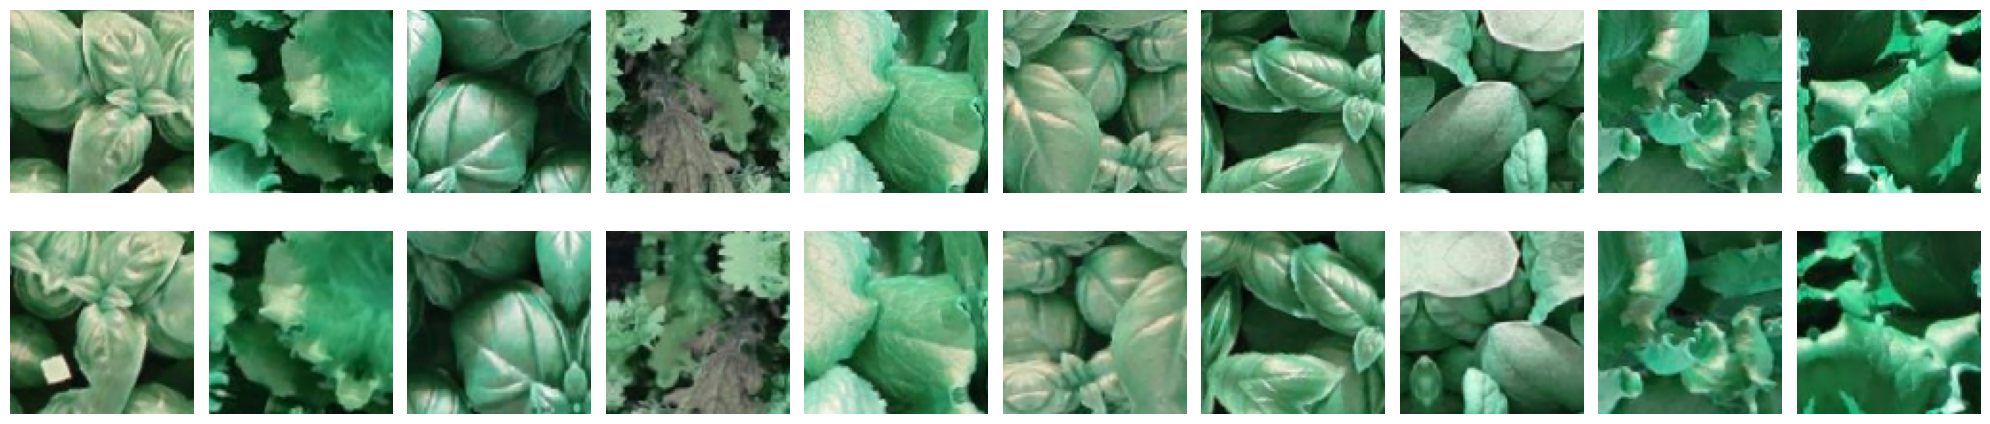

In [ ]:
# Set the number of images to plot
num_images = 10

# Create a figure with the specified number of subplots
fig, axes = plt.subplots(2, num_images, figsize=(20, 5))

# Loop through the images and plot them
for i in range(num_images):
    # Plot the original image
    axes[0, i].imshow(X_train[i])
    axes[0, i].axis("off")

    # Generate an augmented image
    augmented_image = trainAug.random_transform(X_train[i])

    # Plot the augmented image
    axes[1, i].imshow(augmented_image)
    axes[1, i].axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

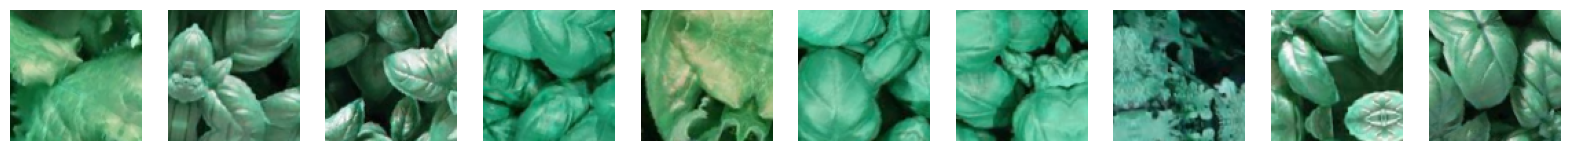

In [ ]:
# Set the figure size
plt.figure(figsize=(20, 5))

# Loop through the augmented images
for i, image in enumerate(trainAug.flow(X_train, batch_size=1)):
    # Display the image
    plt.subplot(1, 10, i+1)  # Create a subplot for each image
    plt.imshow(image[0])
    plt.axis("off")

    if i == 9:  # Break the loop after displaying 10 images
        break

plt.show()

In [ ]:
effinet = EfficientNetB0(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
)

# Freeze the weights of the  model
effinet.trainable = False

last_layer = effinet.get_layer('block6d_add')
last_output = last_layer.output
# for layer in mobile.layers:
#    print(layer, layer.trainable)

flat = tf.keras.layers.GlobalAveragePooling2D()(last_output)
dense1 = tf.keras.layers.Dense(1024, activation='relu')(flat)
dropout = tf.keras.layers.Dropout(0.2)(dense1)
dense2 = tf.keras.layers.Dense(512, activation='relu')(dropout)
gaussian_noise = tf.keras.layers.GaussianNoise(0.1)(dense2)
predictions = tf.keras.layers.Dense(2, activation='sigmoid')(gaussian_noise)

tl_model = Model(inputs = effinet.input, outputs = predictions, name="TL_efficient")

# Display model summary
# tl_model.summary()

In [ ]:
# Set all EfficientNet layers as trainable
tl_model.trainable = True
# Freeze first N layers, e.g., until the 222 one
N = 222
for i, layer in enumerate(tl_model.layers[:N]):
  layer.trainable=False
# Freeze batch normalization layer
for layer in tl_model.layers:
    if 'bn' in layer.name:
        layer.trainable = False

for i, layer in enumerate(tl_model.layers):
   print(i, layer.name, layer.trainable)

0 input_14 False
1 rescaling_24 False
2 normalization_12 False
3 rescaling_25 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1, restore_best_weights=True)

# Compile the model with Binary Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

tl_history = tl_model.fit(trainAug.flow(X_train*255, y_train, batch_size=32),
                          validation_data=((X_val*255), y_val),
                          steps_per_epoch = len(X_train) // 32,
                          epochs=200,
                          callbacks = [early_stopping]).history

Epoch 1/200
121/121 [==============================] - 24s 118ms/step - loss: 0.6658 - accuracy: 0.6952 - val_loss: 0.4723 - val_accuracy: 0.7818
Epoch 2/200
121/121 [==============================] - 13s 108ms/step - loss: 0.5394 - accuracy: 0.7487 - val_loss: 0.4463 - val_accuracy: 0.7938
Epoch 3/200
121/121 [==============================] - 13s 106ms/step - loss: 0.4948 - accuracy: 0.7710 - val_loss: 0.4267 - val_accuracy: 0.8144
Epoch 4/200
121/121 [==============================] - 10s 85ms/step - loss: 0.4674 - accuracy: 0.7799 - val_loss: 0.4431 - val_accuracy: 0.8041
Epoch 5/200
121/121 [==============================] - 15s 123ms/step - loss: 0.4552 - accuracy: 0.7934 - val_loss: 0.4326 - val_accuracy: 0.8110
Epoch 6/200
121/121 [==============================] - 10s 85ms/step - loss: 0.4526 - accuracy: 0.8033 - val_loss: 0.4303 - val_accuracy: 0.8144
Epoch 7/200
121/121 [==============================] - 12s 101ms/step - loss: 0.4349 - accuracy: 0.8012 - val_loss: 0.4414 - v

In [ ]:
test_loss, test_accuracy = tl_model.evaluate(X_test*255, y_test)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

13/13 [==============================] - 0s 23ms/step - loss: 0.2782 - accuracy: 0.8711
Test Accuracy: 0.8711340427398682


Try the test accuracy also on the augmented images in order to understand if the model can generalize in a good way or not

In [ ]:
test_loss, test_accuracy = tl_model.evaluate(X_test_augmented*255, y_test_augmented)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

122/122 [==============================] - 3s 20ms/step - loss: 0.3132 - accuracy: 0.8649
Test Accuracy: 0.8649484515190125


In [ ]:
predictions = tl_model.predict(X_test*255)
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), target_names=["healty","unhealty"]))

13/13 [==============================] - 2s 22ms/step
              precision    recall  f1-score   support

      healty       0.89      0.92      0.90       251
    unhealty       0.84      0.79      0.81       137

    accuracy                           0.87       388
   macro avg       0.86      0.85      0.86       388
weighted avg       0.87      0.87      0.87       388



In [ ]:
predictions = tl_model.predict(X_test_augmented*255)
print(classification_report(np.argmax(y_test_augmented, axis=-1), np.argmax(predictions, axis=-1), target_names=["healty","unhealty"]))

122/122 [==============================] - 2s 16ms/step
              precision    recall  f1-score   support

      healty       0.88      0.91      0.89      2450
    unhealty       0.84      0.79      0.81      1430

    accuracy                           0.86      3880
   macro avg       0.86      0.85      0.85      3880
weighted avg       0.86      0.86      0.86      3880



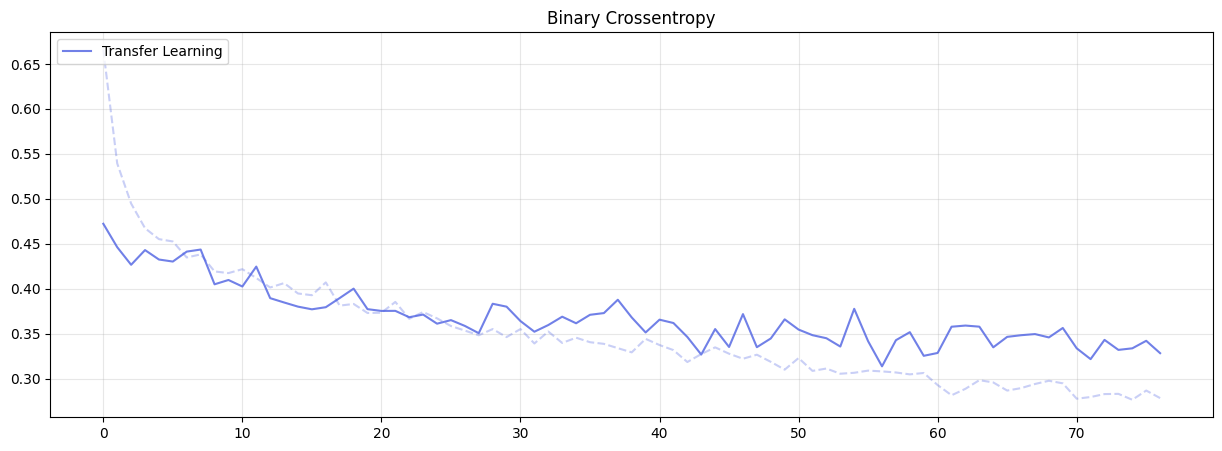

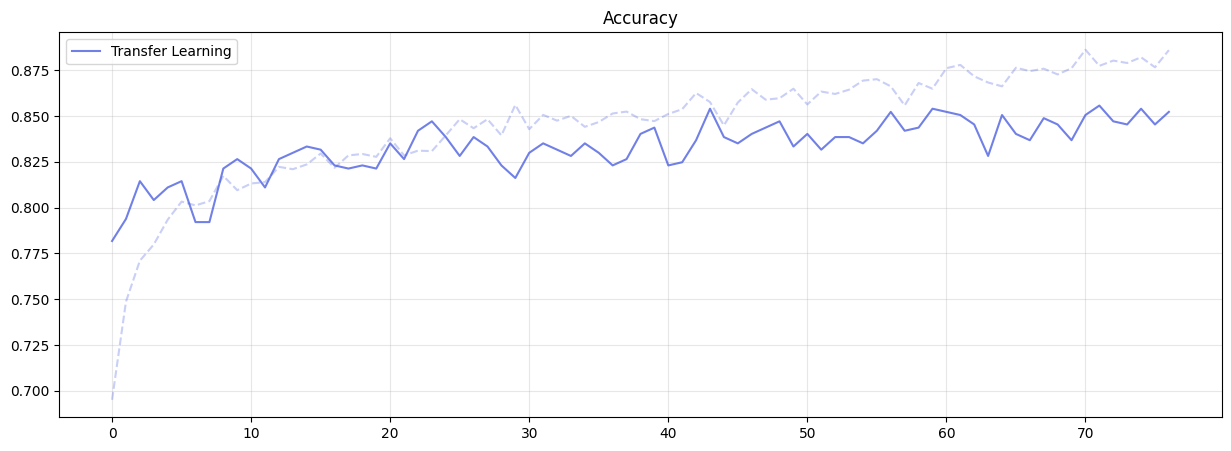

In [ ]:
# Plot the re-trained and the transfer learning of EfficientNetB0 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='val_loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='val_accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
tl_model.save("tl_final_good")

## Transfer Learning of EfficientNetB0 second phase

This is the transfer learning of EfficientNetB0 that in the second phase gave us on codaLab 76% accuracy.

In [ ]:
def calculate_class_weights(y):
    # Convert one-hot encoded labels to integer labels
    y_int = np.argmax(y, axis=1)

    # Calculate the class frequencies
    class_counts = np.bincount(y_int)

    # Calculate the class weights
    total_samples = np.sum(class_counts)
    class_weights = {class_index: total_samples / (len(class_counts) * class_count) for class_index, class_count in enumerate(class_counts)}

    return class_weights

class_weights = calculate_class_weights(y_train)
print(class_weights)

{0: 0.7918367346938775, 1: 1.3566433566433567}


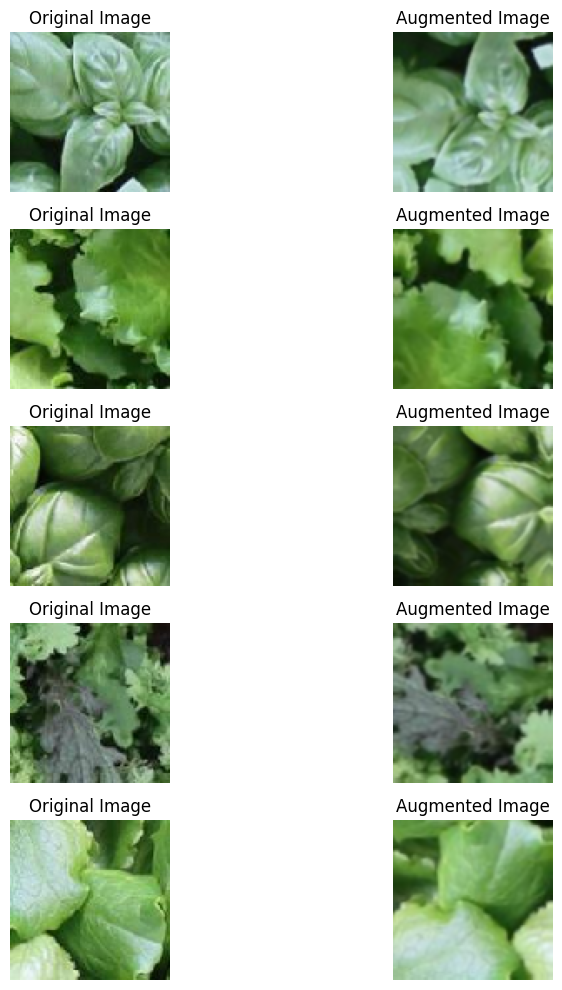

In [ ]:
num_images = 5  # Number of images to plot
augmented = data_augmentation1(X_train[:5]*255)

fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))
for i in range(num_images):
    axes[i, 0].imshow(X_train[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(augmented[i]/255.0)
    axes[i, 1].set_title("Augmented Image")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Define the input tensor
inputs = tf.keras.Input(shape=(96, 96, 3))

# Apply data augmentation
x = data_augmentation(inputs)

# Apply the EfficientNetB0 layers
efficientNet = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=x
)

efficientNet.trainable = False

last_layer = efficientNet.get_layer('block6d_add')
x = last_layer.output

# Pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Dense layers
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

# Gaussian noise layer
x = tf.keras.layers.GaussianNoise(0.2)(x)

# Output layer
predictions = tf.keras.layers.Dense(2, activation='sigmoid')(x)

# Create the model
tl_model = tf.keras.Model(inputs=inputs, outputs=predictions, name="TL_efficient")

In [ ]:
# Set all EfficientNet layers as trainable
tl_model.trainable = True
# Freeze first N layers, e.g., until the 222 one
N = 77
for i, layer in enumerate(tl_model.layers[:N]):
  layer.trainable=False
# Freeze batch normalization layer
for layer in tl_model.layers:
    if 'bn' in layer.name:
        layer.trainable = False

for i, layer in enumerate(tl_model.layers):
   print(i, layer.name, layer.trainable)

0 input_7 False
1 sequential_1 False
2 rescaling_12 False
3 normalization_6 False
4 rescaling_13 False
5 stem_conv_pad False
6 stem_conv False
7 stem_bn False
8 stem_activation False
9 block1a_dwconv False
10 block1a_bn False
11 block1a_activation False
12 block1a_se_squeeze False
13 block1a_se_reshape False
14 block1a_se_reduce False
15 block1a_se_expand False
16 block1a_se_excite False
17 block1a_project_conv False
18 block1a_project_bn False
19 block2a_expand_conv False
20 block2a_expand_bn False
21 block2a_expand_activation False
22 block2a_dwconv_pad False
23 block2a_dwconv False
24 block2a_bn False
25 block2a_activation False
26 block2a_se_squeeze False
27 block2a_se_reshape False
28 block2a_se_reduce False
29 block2a_se_expand False
30 block2a_se_excite False
31 block2a_project_conv False
32 block2a_project_bn False
33 block2b_expand_conv False
34 block2b_expand_bn False
35 block2b_expand_activation False
36 block2b_dwconv False
37 block2b_bn False
38 block2b_activation False
39

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=12, mode='min', verbose=1, restore_best_weights=True)

def lr_schedule(epoch):
    if epoch < 100:
      return 6e-6
    else:
      return 1e-7

# Create LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Compile the model with Binary Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(6e-6), metrics=['accuracy'])

tl_history = tl_model.fit(X_train*255,
                          y_train,
                          batch_size=32,
                          validation_data=((X_val*255), y_val),
                          epochs=500,
                          class_weight=class_weights,
                          callbacks = [early_stopping]).history

Epoch 1/500
122/122 [==============================] - 24s 61ms/step - loss: 1.1127 - accuracy: 0.5446 - val_loss: 0.8183 - val_accuracy: 0.4708
Epoch 2/500
122/122 [==============================] - 4s 34ms/step - loss: 0.8827 - accuracy: 0.5407 - val_loss: 0.7237 - val_accuracy: 0.5550
Epoch 3/500
122/122 [==============================] - 4s 33ms/step - loss: 0.7840 - accuracy: 0.5825 - val_loss: 0.6746 - val_accuracy: 0.5962
Epoch 4/500
122/122 [==============================] - 5s 42ms/step - loss: 0.7407 - accuracy: 0.5987 - val_loss: 0.6453 - val_accuracy: 0.6237
Epoch 5/500
122/122 [==============================] - 5s 38ms/step - loss: 0.6975 - accuracy: 0.6299 - val_loss: 0.6171 - val_accuracy: 0.6581
Epoch 6/500
122/122 [==============================] - 4s 34ms/step - loss: 0.6709 - accuracy: 0.6536 - val_loss: 0.5903 - val_accuracy: 0.6856
Epoch 7/500
122/122 [==============================] - 5s 41ms/step - loss: 0.6538 - accuracy: 0.6696 - val_loss: 0.5677 - val_accuracy

In [ ]:
test_loss, test_accuracy = tl_model.evaluate(X_test*255, y_test)

# Print the test accuracy
print("Test Accuracy:", test_accuracy*100)

13/13 [==============================] - 0s 24ms/step - loss: 0.2643 - accuracy: 0.8763
Test Accuracy: 87.6288652420044


In [ ]:
test_loss, test_accuracy = tl_model.evaluate(augmented_images*255, augmented_labels)

# Print the test accuracy
print("Test Accuracy:", test_accuracy*100)

230/230 [==============================] - 4s 18ms/step - loss: 0.4747 - accuracy: 0.8244
Test Accuracy: 82.43537545204163


In [ ]:
predictions = tl_model.predict(X_test*255)
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), target_names=["healty","unhealty"]))

13/13 [==============================] - 2s 21ms/step
              precision    recall  f1-score   support

      healty       0.91      0.94      0.93       251
    unhealty       0.88      0.83      0.86       137

    accuracy                           0.90       388
   macro avg       0.90      0.89      0.89       388
weighted avg       0.90      0.90      0.90       388



In [ ]:
predictions = tl_model.predict(augmented_images*255)
print(classification_report(np.argmax(augmented_labels, axis=-1), np.argmax(predictions, axis=-1), target_names=["healty","unhealty"]))

230/230 [==============================] - 4s 17ms/step
              precision    recall  f1-score   support

      healty       0.77      0.91      0.84      3629
    unhealty       0.89      0.74      0.81      3721

    accuracy                           0.82      7350
   macro avg       0.83      0.83      0.82      7350
weighted avg       0.83      0.82      0.82      7350



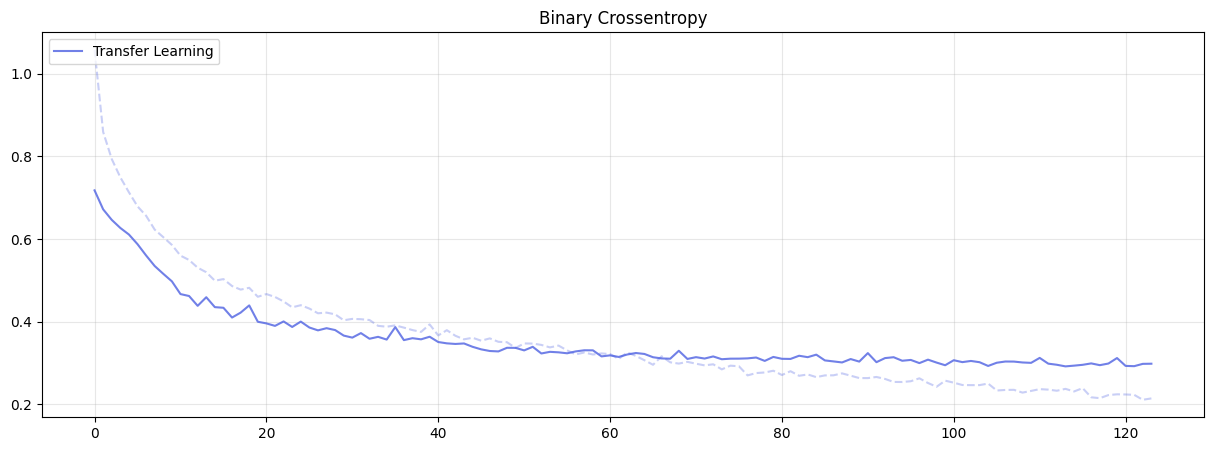

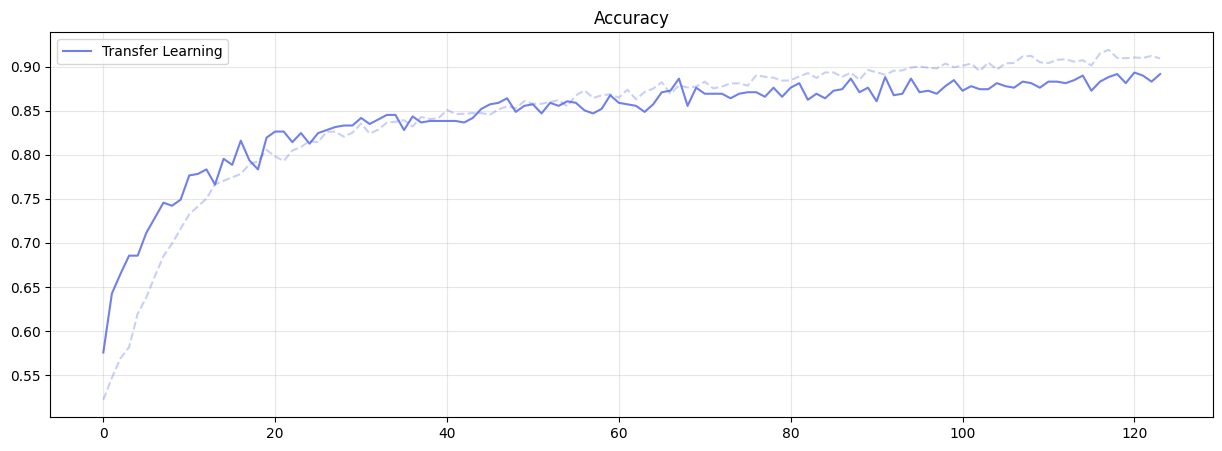

In [ ]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
tl_model.save("New_Simo_6")

## Transfer Learning of ConvNeXT Base second phase

This is the transfer learning of ConvNeXT Base that gava us 80% accuracy on CodaLab in the second phase.

In [ ]:
def calculate_class_weights(y):
    # Convert one-hot encoded labels to integer labels
    y_int = np.argmax(y, axis=1)

    # Calculate the class frequencies
    class_counts = np.bincount(y_int)

    # Calculate the class weights
    total_samples = np.sum(class_counts)
    class_weights = {class_index: total_samples / (len(class_counts) * class_count) for class_index, class_count in enumerate(class_counts)}

    return class_weights

class_weights = calculate_class_weights(y_train)
print(class_weights)

{0: 0.7918367346938775, 1: 1.3566433566433567}


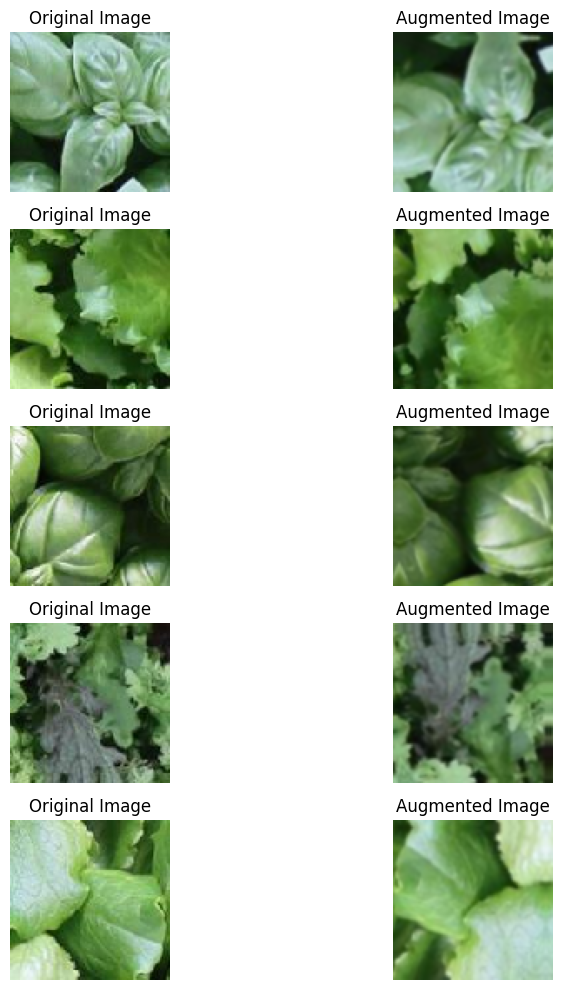

In [ ]:
num_images = 5  # Number of images to plot
augmented = data_augmentation2(X_train[:5]*255)

fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))
for i in range(num_images):
    axes[i, 0].imshow(X_train[i])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(augmented[i]/255.0)
    axes[i, 1].set_title("Augmented Image")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

Our fully connected network consists in a global average pooling layer followed by a dropout (rate = 0.2), a dense layer composed by 512 neurons and ‘relu’ activation function, another dropout layer with the same rate, a layer that introduces some gaussian noise to the input with a standard deviation of 0.1 and finally another dense layer with only 2 neurons because we have only 2 classes .


In [ ]:
convNet = ConvNeXtBase(
    include_top=False,
    weights="imagenet",
    input_shape=(96, 96, 3)
)

# Freeze the convNet layers
convNet.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(96, 96, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# convNet is running in inference mode here.
x = convNet(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = (tf.keras.layers.Dropout(0.2))(x)
x = (tf.keras.layers.Dense(512, activation='relu'))(x)
x = (tf.keras.layers.Dropout(0.2))(x)
x = (tf.keras.layers.GaussianNoise(0.1))(x)
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)
conv_model = tf.keras.Model(inputs, outputs)

conv_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 convnext_base (Functional)  (None, 3, 3, 1024)        87566464  
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               524800    
                                                           

In [ ]:
for i, layer in enumerate(conv_model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 sequential_1 True
2 convnext_base False
3 global_average_pooling2d True
4 dropout True
5 dense True
6 dropout_1 True
7 gaussian_noise True
8 dense_1 True


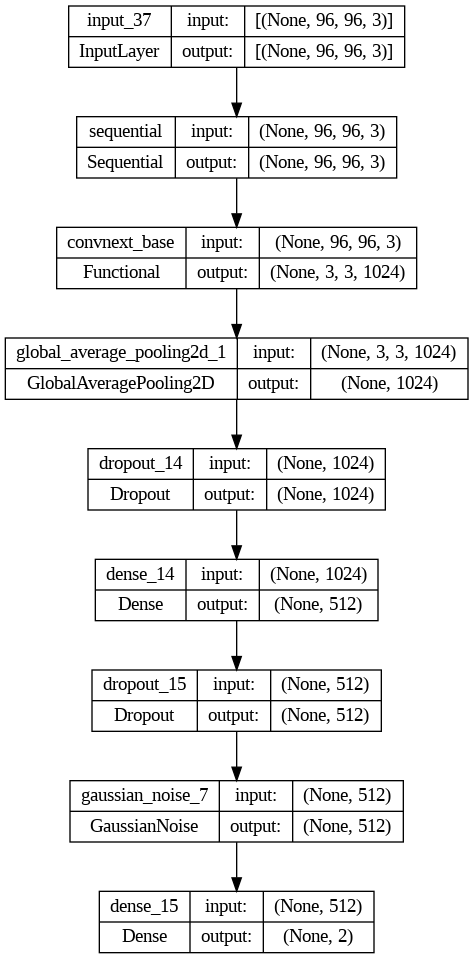

In [ ]:
tf.keras.utils.plot_model(conv_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', verbose=1, restore_best_weights=True)

def lr_schedule(epoch):
    max_epochs = 100
    max_lr = 1e-4
    min_lr = 1e-5
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(epoch / max_epochs * math.pi))

# Create LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

callbacks = [early_stopping,lr_scheduler]

# Compile the model with Binary Cross-Entropy loss and AdamW optimizer
conv_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-4), metrics=['accuracy'])

# Train the model
history = conv_model.fit(X_train*255,
                        y_train,
                        batch_size=32,
                        validation_data=((X_val*255), y_val),
                        epochs=500,
                        class_weight = class_weights,
                        callbacks = callbacks).history


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/500
122/122 [==============================] - 66s 270ms/step - loss: 0.6217 - accuracy: 0.6835 - val_loss: 0.5103 - val_accuracy: 0.7663 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.997779521645793e-05.
Epoch 2/500
122/122 [==============================] - 20s 166ms/step - loss: 0.5079 - accuracy: 0.7750 - val_loss: 0.4579 - val_accuracy: 0.7938 - lr: 9.9978e-05

Epoch 3: LearningRateScheduler setting learning rate to 9.991120277927223e-05.
Epoch 3/500
122/122 [==============================] - 19s 159ms/step - loss: 0.4683 - accuracy: 0.7794 - val_loss: 0.4700 - val_accuracy: 0.7715 - lr: 9.9911e-05

Epoch 4: LearningRateScheduler setting learning rate to 9.98002884071386e-05.
Epoch 4/500
122/122 [==============================] - 20s 167ms/step - loss: 0.4583 - accuracy: 0.7866 - val_loss: 0.4228 - val_accuracy: 0.7904 - lr: 9.9800e-05

Epoch 5: LearningRateScheduler setting lear

In [ ]:
test_loss, test_accuracy = conv_model.evaluate(X_test*255, y_test)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

13/13 [==============================] - 2s 123ms/step - loss: 0.2603 - accuracy: 0.8995
Test Accuracy: 0.8994845151901245


In [ ]:
predictions = conv_model.predict(X_test*255)
print(classification_report(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), target_names=["healty","unhealty"]))

13/13 [==============================] - 2s 136ms/step
              precision    recall  f1-score   support

      healty       0.91      0.94      0.92       251
    unhealty       0.88      0.83      0.85       137

    accuracy                           0.90       388
   macro avg       0.89      0.88      0.89       388
weighted avg       0.90      0.90      0.90       388



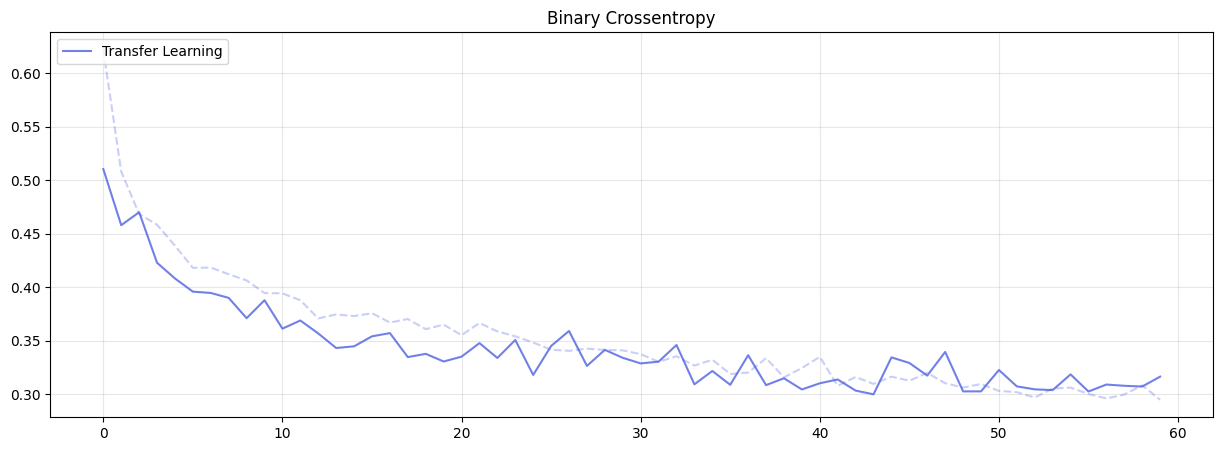

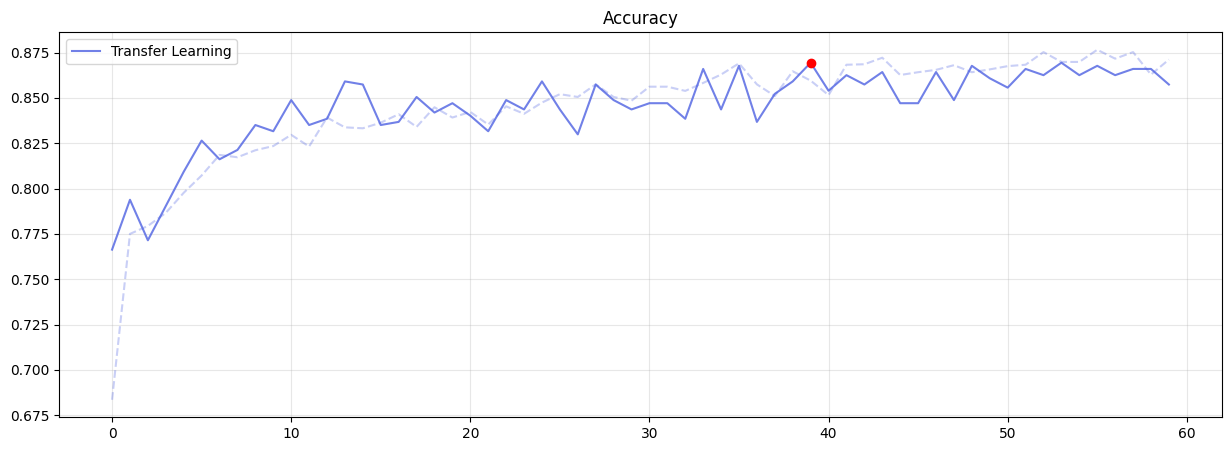

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

# Highlight best epoch
best_epoch = np.argmax(history['val_accuracy'])
plt.plot(best_epoch, history['val_accuracy'][best_epoch], 'ro')

plt.show()

In [ ]:
conv_model.save("AdaW_ConvNeXT")

##Fine Tuning of 'AdamW_ConvNeXT'

This is the part of fine tuning of AdamW_ConvNeXT that gave us 80% accuracy in the second phase on CodaLab

In [ ]:
# Load the model
conv_model = tf.keras.models.load_model('AdamW_ConvNeXT')

In [ ]:
# Set all ConvNeXT Base layers as trainable
conv_model.get_layer("convnext_base").trainable = True
# Freeze first N layers
"""
N = 26
for i, layer in enumerate(conv_model.get_layer("convnext_base").layers[:N]):
  layer.trainable=False

"""

'\nN = 26\nfor i, layer in enumerate(conv_model.get_layer("convnext_base").layers[:N]):\n  layer.trainable=False\n\n'

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, mode='max', verbose=1, restore_best_weights=True)

def lr_schedule(epoch):
    max_epochs = 100
    max_lr = 1e-5
    min_lr = 1e-8
    return min_lr + 0.5 * (max_lr - min_lr) * (1 + math.cos(epoch / max_epochs * math.pi))

# Create LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

#Define the callbacks to use
callbacks = [early_stopping,lr_scheduler]

# Compile the model with Binary Cross-Entropy loss and AdamW optimizer
conv_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-3), metrics=['accuracy'])

# Train the model
history = conv_model.fit(X_train*255,
                        y_train,
                        batch_size=32,
                        validation_data=((X_val*255), y_val),
                        epochs=200,
                        class_weight = class_weights,
                        callbacks = callbacks).history


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/200
122/122 [==============================] - 172s 583ms/step - loss: 0.3059 - accuracy: 0.8698 - val_loss: 0.3075 - val_accuracy: 0.8591 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.99753526902683e-06.
Epoch 2/200
122/122 [==============================] - 50s 407ms/step - loss: 0.2591 - accuracy: 0.8923 - val_loss: 0.2897 - val_accuracy: 0.8814 - lr: 9.9975e-06

Epoch 3: LearningRateScheduler setting learning rate to 9.990143508499217e-06.
Epoch 3/200
122/122 [==============================] - 49s 406ms/step - loss: 0.2316 - accuracy: 0.9049 - val_loss: 0.3161 - val_accuracy: 0.8643 - lr: 9.9901e-06

Epoch 4: LearningRateScheduler setting learning rate to 9.977832013192386e-06.
Epoch 4/200
122/122 [==============================] - 50s 410ms/step - loss: 0.2101 - accuracy: 0.9178 - val_loss: 0.2845 - val_accuracy: 0.8832 - lr: 9.9778e-06

Epoch 5: LearningRateScheduler setting lear

In [ ]:
test_loss, test_accuracy = conv_model.evaluate(X_test*255, y_test)

# Print the test accuracy
print("Test Accuracy:", test_accuracy)

13/13 [==============================] - 5s 388ms/step - loss: 0.2286 - accuracy: 0.9588
Test Accuracy: 0.9587628841400146


In [ ]:
conv_model.save("TuttiLayersUnfreezati9587_overfittato")

## Ensemble Model

We tried also to submit an ensemble model made of 3 different models that we uploaded on CodaLab in the developement phase.

This ensemble model gave us 82% accuracy on CodaLab.

In [ ]:
# Re-load the models
model_1 = tfk.models.load_model('0.82-EfficientNet_TransferLearning') #82% accuracy on CodaLab
model_2 = tfk.models.load_model('0.83EfficientNet_su_codalab') #83% accuracy on CodaLab
model_3 = tfk.models.load_model('ConvexNeXtBaseLessPatience') #82% accuracy on CodaLab

In [ ]:
out1 = model_1.predict(X_test*255)
out2 = model_2.predict(X_test*255)
out3 = model_3.predict(X_test*255)

#calculate the average of the three model outputs
ensemble_predictions = np.mean([out1, out2, out3], axis=0)

#majority voting: determine the index of the maximum value that is the predicted class
predicted_classes = np.argmax(ensemble_predictions, axis=1)

13/13 [==============================] - 13s 449ms/step


In [ ]:
# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), predicted_classes)
precision = precision_score(np.argmax(y_test, axis=-1), predicted_classes, average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), predicted_classes, average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), predicted_classes, average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

Accuracy: 0.9124
Precision: 0.916
Recall: 0.8908
F1: 0.9013


In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), predicted_classes)

# Display the confusion matrix
print(cm)

[[242   9]
 [ 25 112]]
